In [ ]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import h5py
import matplotlib.pyplot as plt
'''import inflect
c2h.stringify = inflect.engine()'''
from tqdm import tqdm
from collections import Counter
import csv_to_hdf5 as c2h

In [ ]:
creepmeter_metadata = pd.read_excel('../../Data/Creepmeter_list.xlsx')
creepmeter_metadata

In [ ]:
# Example usage
directory = '../../Data/DATA_tidied/CSV/'  # Replace with your actual directory path
files = c2h.list_files_in_directory(directory)
print(files)
try:
    Creepmeter_dataframe = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation.csv',index_col=0)
except FileNotFoundError:
    Creepmeter_dataframe = pd.DataFrame()

print(Creepmeter_dataframe)

In [ ]:
del files[6]
print(files)


In [8]:
files = ['gb.csv','gd.csv','gs.csv','r7.csv','ra.csv','rb.csv']

In [ ]:
files.sort()
diff_all = []
count = 0
for file in tqdm(files):
    data = pd.read_csv(directory + file,index_col=0)
    try:
        #print(data['Time'].head(10))
        data['Time'] = pd.to_datetime(data['Time'])
    except KeyError:
        #print(data['Date'].head(10))
        data['Time'] = pd.to_datetime(data['Date'])
    tm_diff = np.diff(data['Time'])/ np.timedelta64(1, 'm')
    negatives = np.any(tm_diff<0)
    if negatives == True:
        where_neg = np.where(tm_diff<0)[0]
        count+=1
        print(where_neg)
        for i in range(len(where_neg)):
            print(data.loc[where_neg[i]-10:where_neg[i]+10])
        print(file, 'negatives!!')
    diff_all.extend(np.unique(tm_diff))
print(count)

GB
GD
GS
R7
RA
RB


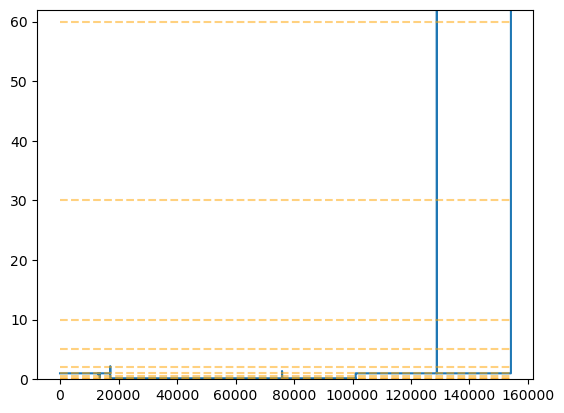

Top 4 modes and their frequencies: [(0.16666666666666666, 83902), (1.0, 70253)]
[0.16666666666666666, 1.0]
83906 83891
[17179 83891]
                      Date    Slip                Time   tm_diff
0      2019-07-09 02:11:18  0.9120 2019-07-09 02:11:18       1.0
1      2019-07-09 02:12:18  0.9115 2019-07-09 02:12:18       1.0
2      2019-07-09 02:13:18  0.9345 2019-07-09 02:13:18       1.0
3      2019-07-09 02:14:18  0.9327 2019-07-09 02:14:18       1.0
4      2019-07-09 02:15:18  0.9328 2019-07-09 02:15:18       1.0
...                    ...     ...                 ...       ...
70269  2019-09-05 15:30:34  1.6593 2019-09-05 15:30:34       1.0
70270  2019-09-05 15:31:34  1.6591 2019-09-05 15:31:34       1.0
70271  2019-09-05 15:32:34  1.6593 2019-09-05 15:32:34       1.0
70272  2019-09-05 15:33:34  1.6593 2019-09-05 15:33:34       1.0
70273  2019-09-05 15:34:34  1.6633 2019-09-05 15:34:34  123456.0

[70274 rows x 4 columns]
                      Date    Slip                Time   tm_d

In [36]:
import importlib
importlib.reload(c2h)
for file in files:
    # Extract the first 4 letters in uppercase
    abbreviation = file[:2].upper()
    print(abbreviation)
    fn = '{k}'.format(k=abbreviation)
    prefix = 'Slip'
    index_CM = np.where(creepmeter_metadata['Creepmeter_abbrv']==abbreviation)[0][0]
    latitude = creepmeter_metadata['Latitude'].iloc[index_CM]
    longitude = creepmeter_metadata['Longitude'].iloc[index_CM]
    depth = creepmeter_metadata['Depth'].iloc[index_CM]
    length = creepmeter_metadata['Length'].iloc[index_CM]
    obliquity = creepmeter_metadata['Obliquity'].iloc[index_CM]
    network = creepmeter_metadata['Network'].iloc[index_CM]
    full_name = creepmeter_metadata['Creepmeter_full_name'].iloc[index_CM]
    
    hdf5_path = '../../Data/DATA_tidied/HDF5/' + fn +'.h5'

    if not os.path.isfile(hdf5_path):
        data = pd.read_csv(directory + file,index_col=0)
        try:
            data['Time'] = pd.to_datetime(data['Time'])
        except KeyError:
            data['Time'] = pd.to_datetime(data['Date'])

        tm_diff = np.diff(data['Time'])/ np.timedelta64(1, 'm')
        tm_diff = np.append(tm_diff,123456)
        #tm_diff = c2h.round_to_nearest_half(tm_diff)
        data['tm_diff'] = tm_diff
        data.dropna(inplace=True)
        #data['tm_diff'] = c2h.round_to_nearest_half(data['tm_diff'])
        data.reset_index(inplace=True,drop=True)
        

        boolarr = tm_diff <1/60
        same_time = tm_diff[boolarr] 

        if len(same_time) >0:
            datapoint_to_drop = np.where(tm_diff <1/60)[0][0]
            data.drop(datapoint_to_drop,inplace=True)
            data.reset_index(inplace=True)
            data.drop(['index'],axis=1,inplace=True)
            boolarr_diff = tm_diff >= 1/60
            tm_diff = tm_diff[boolarr_diff]
        data.drop(data.loc[data.Time.isnull()].index,inplace=True)
        data.reset_index(inplace=True,drop=True) 
        data['Slip'] = data['Slip'].astype(float)

        plt.figure()
        ax = plt.subplot(1,1,1)
        plt.plot(tm_diff)
        plt.ylim(0,62)
        plt.hlines([1/60,1/6,1/2,1,2,5,10,30,60],xmin=0,xmax=len(tm_diff),colors='orange',linestyles='--',alpha=0.5)
        plt.show()

        allowed_modes = [1/60,1/6,1/2,1,2,5,10,30,60]
        top_4_modes = c2h.find_top_modes(tm_diff, 4,allowed_modes)
        print("Top 4 modes and their frequencies:", top_4_modes)
        no_mode = input('how many sampling frequencies?')
        reversal = input('does the smaple rate revert to an earlier one? (y/n)')
        periods = []
        for q in range(int(no_mode)):
            periods.append(top_4_modes[q][0])
        print(periods)



        if len(periods)==3:
            a = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
            b = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
            c = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[2])))
            d = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[0])))
            e = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[2])))
            f = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[1])))

            indices = sorted([a,b,c,d,e,f])
            unique_ind = np.unique(indices)
            creeping_A = data.iloc[:unique_ind[1]]      # From start to 'a' (exclusive)
            the_rest = data.iloc[unique_ind[1]:]
            creeping_B = data.iloc[unique_ind[1]:unique_ind[2]]    # From 'a' (inclusive) to 'b' (exclusive)
            creeping_C = data.iloc[unique_ind[2]:]     # From 'b' (inclusive) to 'c' (exclusive)
            
            creeping_A.reset_index(inplace=True,drop=True)
            creeping_B.reset_index(inplace=True,drop=True)
            creeping_C.reset_index(inplace=True,drop=True)
            
            print(creeping_A)
            print(creeping_B)
            print(creeping_C)


        elif len(periods) ==2:
            a = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
            b = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))

            indices = sorted([a,b])
            unique_ind = np.unique(indices)
            creeping_A = data.iloc[:unique_ind[1]]
            the_rest = data.iloc[unique_ind[1]:]
            
            if reversal == 'y':
                the_rest.reset_index(inplace=True,drop=True)
                a = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                b = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                print(a,b)
                if abbreviation == 'R7' or abbreviation == 'RB':
                    a = 17179
                indices = np.unique([a,b])
                print(indices)

                creeping_B = the_rest.iloc[indices[0]:indices[1]]
                creeping_C  = the_rest.iloc[indices[1]:]
                
                creeping_A = pd.concat([creeping_A,creeping_C],ignore_index=True)
                creeping_B.reset_index(inplace=True,drop=True)
                del creeping_C

            else:
                creeping_B = data.iloc[unique_ind[1]:]
                creeping_A.reset_index(inplace=True,drop=True)
                creeping_B.reset_index(inplace=True,drop=True)

            print(creeping_A)
            print(creeping_B)

        elif len(periods) == 1:
            creeping_A = data.iloc[:]
            print(creeping_A)
        
        
        Number_of_splits = []
        Sampling_rates_variable = []
        try:
            sampling_A = c2h.find_top_modes(creeping_A['tm_diff'],1,allowed_modes)[0][0]
            Sampling_rates_variable.append(sampling_A)
            Number_of_splits.append('A')
        except (IndexError, NameError, KeyError):
            sampling_A = 0

        try:
            sampling_B = c2h.find_top_modes(creeping_B['tm_diff'],1,allowed_modes)[0][0]
            Sampling_rates_variable.append(sampling_B)
            Number_of_splits.append('B')
        except (IndexError, NameError, KeyError):
            sampling_B = 0

        try:
            sampling_C = c2h.find_top_modes(creeping_C['tm_diff'],1,allowed_modes)[0][0]
            Sampling_rates_variable.append(sampling_C)
            Number_of_splits.append('C')
        except (IndexError, NameError, KeyError):
            sampling_C = 0

        print(Sampling_rates_variable,Number_of_splits)



        

        
    

        with h5py.File(hdf5_path, 'w') as f:
            f.attrs['author'] = 'Daniel B. Gittins'
            f.attrs['network'] = network
            f.attrs['latitude'] = latitude
            f.attrs['longitude'] = longitude
            f.attrs['depth'] = depth
            f.attrs['length'] = length
            f.attrs['obliquity'] = obliquity
            # Create a group to store both waves together
            for i in range(len(Number_of_splits)):
                smpl_rate = Sampling_rates_variable[i]
                group_name = fn+'_{k}mins'.format(k=smpl_rate)
                time_data = eval('creeping_{k}.Time'.format(k=Number_of_splits[i]))
                # Assuming 'data['Time']' is your pandas Series of datetime objects
                datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()

                dependent_data = eval('creeping_{k}.Slip'.format(k=Number_of_splits[i])).tolist()
                group = f.create_group(group_name)
                # Create datasets for time and dependent variable in the group
                group.create_dataset('Time_{p}_{k}mins'.format(p=abbreviation,k=smpl_rate), data=datetime_strings)
                group.create_dataset('Slip_{p}_{k}mins'.format(p=abbreviation,k=smpl_rate), data=dependent_data)
            
                
                # Store metadata about the dependent variable
                if Sampling_rates_variable[i] >=1:
                    description = f"Slip for {abbreviation} at {smpl_rate} minute sampling"
                else:
                    description = f"Slip for {abbreviation} at {smpl_rate*60} second sampling"
                group.attrs['description'] = description

                
                # Optional: Store additional metadata (e.g., units, sampling rate)
                starttime = eval('creeping_{k}.Time.iloc[0]'.format(k=Number_of_splits[i]))
                endtime = eval('creeping_{k}.Time.iloc[-1]'.format(k=Number_of_splits[i]))
                group.attrs['sampling_rate'] = Sampling_rates_variable[i]  # Example: 100 Hz sampling rate (10 ms interval)
                group.attrs['time_units'] = 'minutes'     # Time units
                group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
                group.attrs['channel'] = 'slip'
                group.attrs['starttime'] = starttime.strftime('%Y-%m-%d %H:%M:%S')
                group.attrs['delta'] = 60*Sampling_rates_variable[i]
                instrument = pd.DataFrame({'Network':[network],'Creepmeter_full_name':[full_name],'Creepmeter_abbrv':[abbreviation],'File_code':[fn],
                                        'Start Time':[starttime],'End Time':[endtime],'Sampling rate, mins':[smpl_rate],
                                        'Latitude':[latitude],'Longitude':[longitude],'Description':[description],'Depth':[depth],'Length':[length],
                                        'Obliquity':[obliquity],'group_name':group_name})
                Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument])
            try:
                del creeping_A
            except NameError:
                dummy=10

            try:
                del creeping_B
            except NameError:
                dummy=10
            try:
                del creeping_C
            except NameError:
                dummy=10
        print('HDF5 structure')
        c2h.print_hdf5_structure('../../Data/DATA_tidied/HDF5/' + fn +'.h5')
        Creepmeter_dataframe.drop_duplicates()
        Creepmeter_dataframe.reset_index(inplace=True,drop=True)
        Creepmeter_dataframe.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation.csv')
print('Creepmeter_meta_data')
print(Creepmeter_dataframe)


In [34]:
data
boolarr = data['tm_diff']==1/6
data[boolarr]

,Date,Slip,Time,tm_diff
17179,2019-07-21 00:30:17,1.3498,2019-07-21 00:30:17,0.166667
17180,2019-07-21 00:30:27,1.3493,2019-07-21 00:30:27,0.166667
17181,2019-07-21 00:30:37,1.3493,2019-07-21 00:30:37,0.166667
17182,2019-07-21 00:30:47,1.3493,2019-07-21 00:30:47,0.166667
17183,2019-07-21 00:30:57,1.3540,2019-07-21 00:30:57,0.166667
...,...,...,...,...
101079,2019-07-30 17:34:40,1.4203,2019-07-30 17:34:40,0.166667
101080,2019-07-30 17:34:50,1.4202,2019-07-30 17:34:50,0.166667
101081,2019-07-30 17:35:00,1.4205,2019-07-30 17:35:00,0.166667
101082,2019-07-30 17:35:10,1.4203,2019-07-30 17:35:10,0.166667


In [ ]:
data['tm_diff'] = tm_diff
np.where(data['tm_diff']=='NaN')

Code below is for importing into Igor

In [ ]:
#pragma TextEncoding = "UTF-8"
#pragma rtGlobals=3
#pragma DefaultTab={3,20,4}

// Creates a date/time wave from a date wave stored as text in YYYY-MM-DD format
// and a time wave stored as text in HH:MM:YY format.
// Example:
//      Make/O/T wDateAsText = {"2016-08-15", "2016-08-15"}
//      Make/O/T wTimeAsText = {"19:01:00", "19:01:18"}
//      TextWavesToDateTimeWave(wDateAsText, wTimeAsText, "wDateTime")
//      Edit wDateTime

Function ConvertTextToDateTime(dateTimeAsText)
    String dateTimeAsText       // Assumed in YYYY-MM-DD HH:MM:SS format
    
    Variable dt
    Variable year, month, day
    Variable hour, minute, second

    // Use sscanf to parse the full datetime string
    sscanf dateTimeAsText, "%d-%d-%d %d:%d:%d", year, month, day, hour, minute, second
    
    // Convert the date part to seconds since the epoch
    dt = Date2Secs(year, month, day)
    
    // Calculate the time of day in seconds
    Variable timeOfDay = 3600 * hour + 60 * minute + second
    
    // Add the time of day to the date
    dt += timeOfDay
    
    return dt
End


Function/WAVE TextWavesToDateTimeWave(dateTimeAsTextWave, outputWaveName)
    WAVE/T dateTimeAsTextWave       // Assumed in YYYY-MM-DD HH:MM:SS format
    String outputWaveName

    Variable numPoints = numpnts(dateTimeAsTextWave)
    Make/O/D/N=(numPoints) $outputWaveName
    WAVE wOut = $outputWaveName
    SetScale d, 0, 0, "dat", wOut
   
    Variable i
    for(i=0; i<numPoints; i+=1)
        String dateTimeAsText = dateTimeAsTextWave[i]
        Variable dt = ConvertTextToDateTime(dateTimeAsText)
        wOut[i] = dt   
    endfor 

    return wOut
End